# Training of an autoencoder using a subset of the images

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import sunpy.map
import cv2
import skimage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg

2023-03-13 10:13:55.253112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading and normalizing the images

In [2]:
# Read images
AIA193_2016 = sunpy.map.Map("data/aia_193A/2016*.fits")
AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))


# Normalize images
min_values = AIA193_2016_matrix.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
max_values = AIA193_2016_matrix.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)) # To avoid dividing by 0

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values) / rg

input_train, input_test = train_test_split(AIA193_2016_mnorm, test_size=0.25)

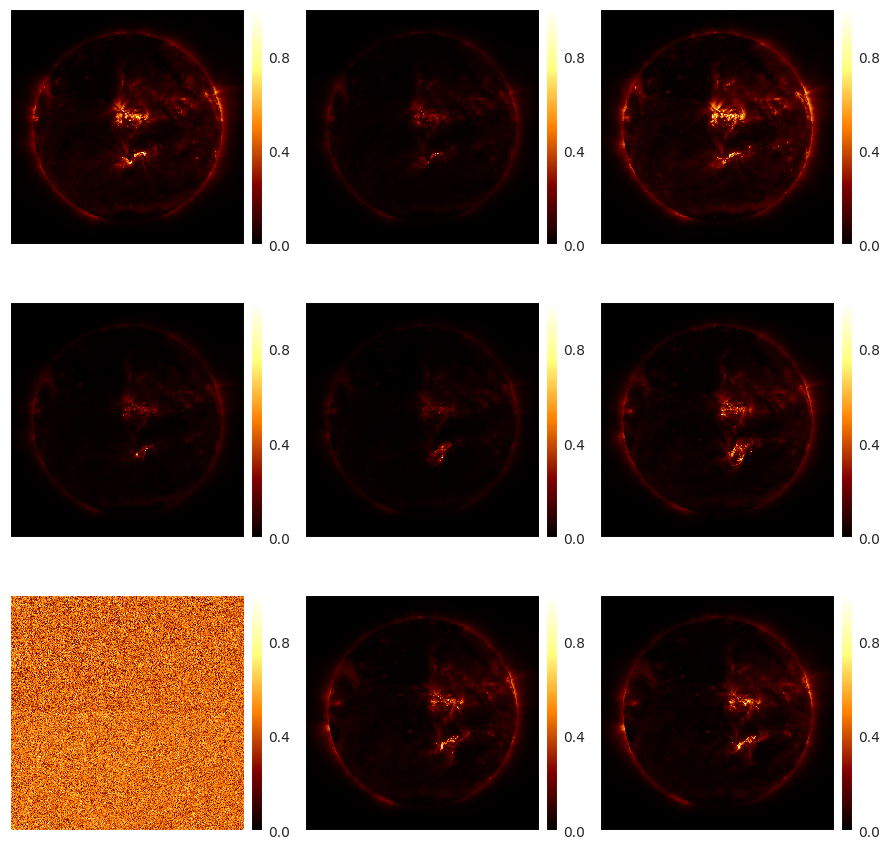

In [3]:
isns.ImageGrid([i for i in AIA193_2016_mnorm[:9]], cmap="afmhot")

## Training the model

In [7]:
latent_size = 96
optimizer = keras.optimizers.Adam(learning_rate=0.001)
autoencoder, encoder, decoder = aem.gen_autoenc_model(latent_size, optim=optimizer, loss="mse")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 8)       80        
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 16)      2320      
                                                           

In [8]:
n_epochs = 200
batch_size = 128

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/200
15/15 [==============================] - 2s 100ms/step - loss: 0.0289 - mae: 0.0911 - val_loss: 0.0204 - val_mae: 0.0892
Epoch 2/200
15/15 [==============================] - 1s 83ms/step - loss: 0.0214 - mae: 0.0968 - val_loss: 0.0103 - val_mae: 0.0638
Epoch 3/200
15/15 [==============================] - 1s 85ms/step - loss: 0.0099 - mae: 0.0488 - val_loss: 0.0060 - val_mae: 0.0440
Epoch 4/200
15/15 [==============================] - 1s 84ms/step - loss: 0.0056 - mae: 0.0418 - val_loss: 0.0048 - val_mae: 0.0403
Epoch 5/200
15/15 [==============================] - 1s 84ms/step - loss: 0.0045 - mae: 0.0378 - val_loss: 0.0039 - val_mae: 0.0343
Epoch 6/200
15/15 [==============================] - 1s 85ms/step - loss: 0.0039 - mae: 0.0341 - val_loss: 0.0033 - val_mae: 0.0307
Epoch 7/200
15/15 [==============================] - 1s 86ms/step - loss: 0.0037 - mae: 0.0319 - val_loss: 0.0032 - val_mae: 0.0299
Epoch 8/200
15/15 [==============================] - 1s 87ms/step - loss: 0

## Evaluating the model

23/23 [==============================] - 1s 16ms/step - loss: 0.0027 - mae: 0.0223


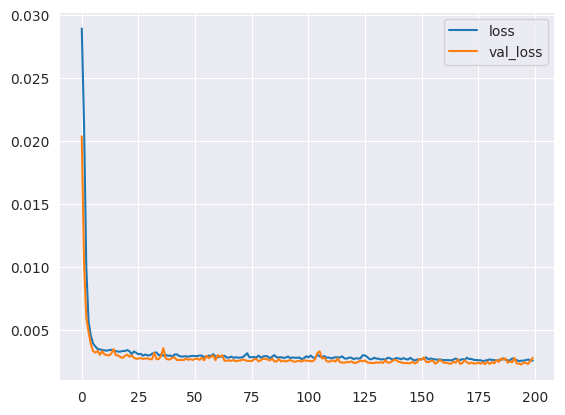

In [9]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 15ms/step


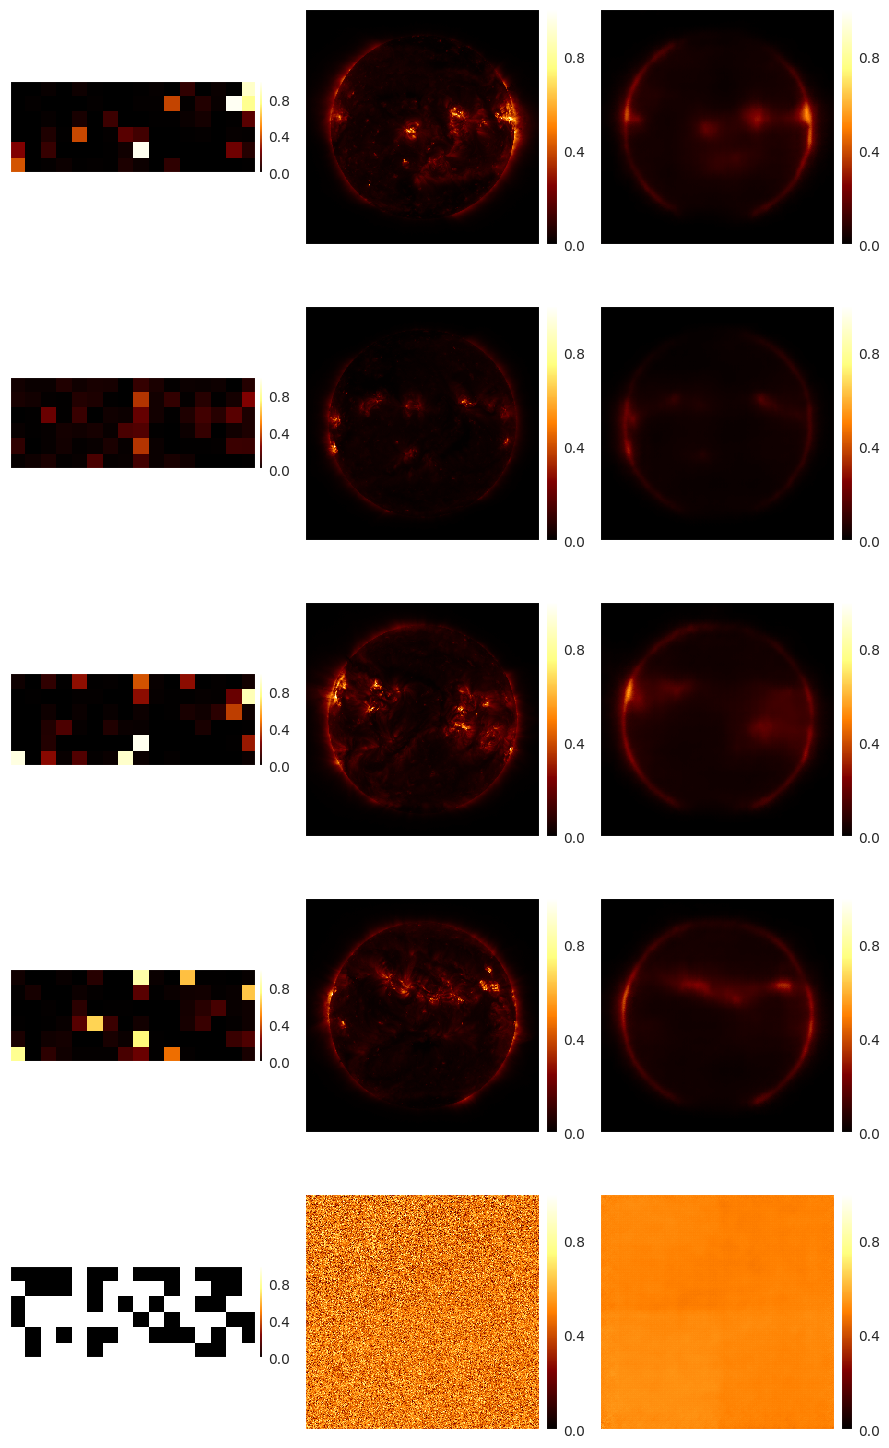

In [12]:
idx = np.random.permutation(80)[:5]

example = input_test[idx]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, example, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.reshape(i[0], [6,16]))
    images.append(np.squeeze(i[1]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap="afmhot", vmin=0, vmax=1, col_wrap=3)

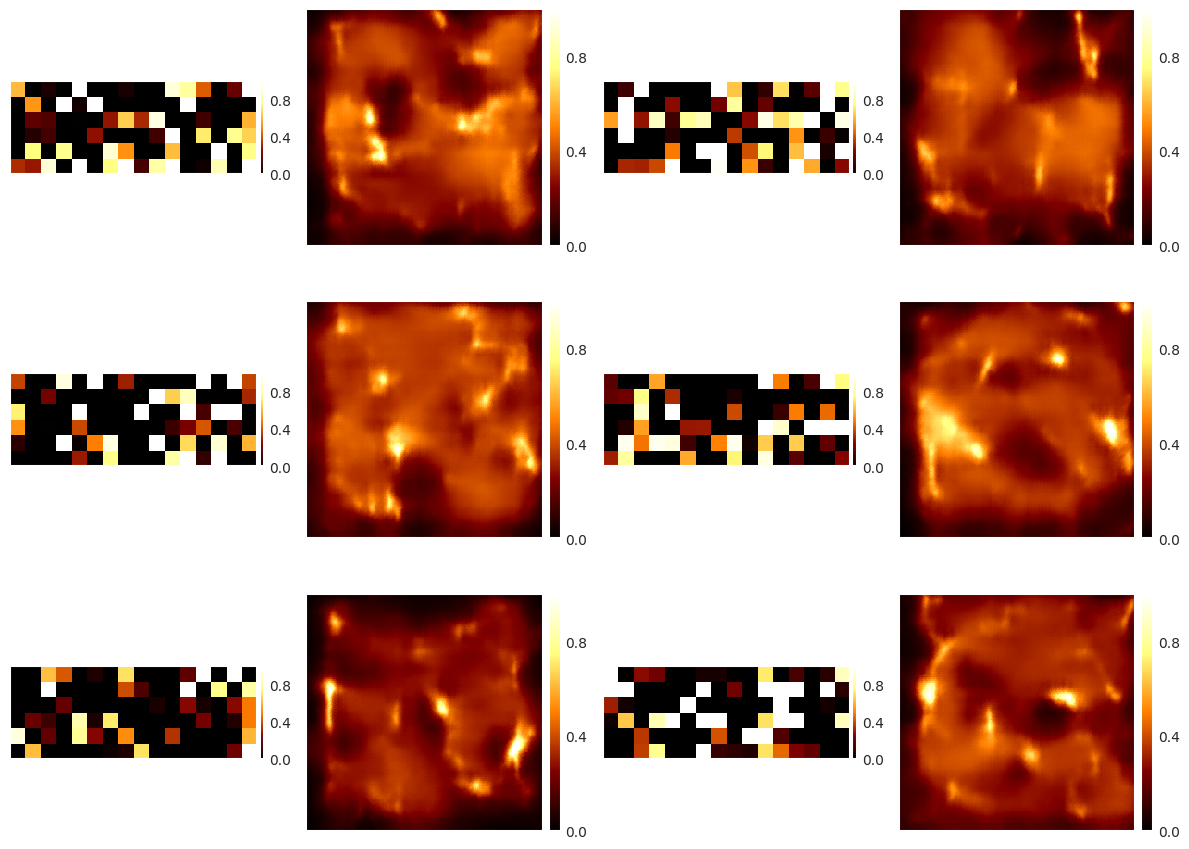

In [13]:
code = np.random.normal(0, 1, [6, latent_size])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.reshape(i[0], [6,16]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap="afmhot", vmin=0, vmax=1, col_wrap=4)